In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Reusar el Dataset personalizado
from PIL import Image
import os

In [ ]:
#Dataset personalizado igual al del entrenamiento de YOLO

class YOLOClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(".jpg")]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_file)
        label_path = os.path.join(self.labels_dir, img_file.replace(".jpg", ".txt"))
        
        # Cargar imagen
        image = Image.open(img_path).convert("RGB")
        
        # Leer etiqueta (primer número del .txt)
        with open(label_path, "r") as f:
            first_line = f.readline().strip()
            class_id = int(first_line.split()[0])
        
        if self.transform:
            image = self.transform(image)
        
        return image, class_id

In [ ]:
#Configuraciones
data_dir = "../../datasets/processed/images"
img_size = 128
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_dataset = YOLOClassificationDataset(
    images_dir=f"{data_dir}/val/images",
    labels_dir=f"{data_dir}/val/labels",
    transform=transform
)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Val dataset: {len(val_dataset)} imágenes")

Val dataset: 164 imágenes


In [ ]:
#Definir modelo y cargar pesos entrenados
class CNNBaseline(nn.Module):
    def __init__(self, num_classes=2):  #cambia si tienes más clases
        super(CNNBaseline, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * (img_size//4) * (img_size//4), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Cargar modelo entrenado
model = CNNBaseline(num_classes=2).to(device)
model.load_state_dict(torch.load("../../models/saved/cnn_baseline.pth", map_location=device))
model.eval()
print("✅ Modelo cargado para evaluación")

✅ Modelo cargado para evaluación


In [ ]:
#Evaluación
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

In [ ]:
#Metricas
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average="weighted")
rec = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.5610
Precision: 0.3147
Recall: 0.5610
F1-score: 0.4032


C:\Users\Sebastian\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


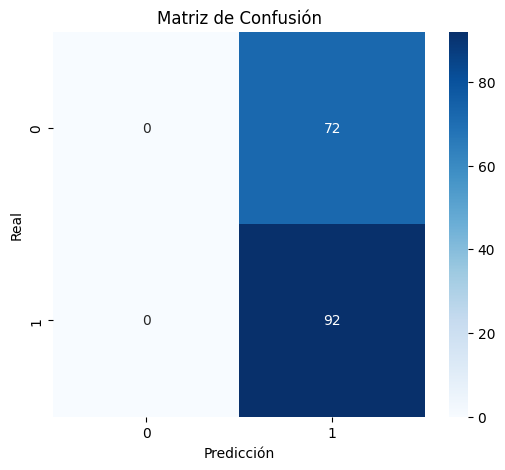

In [7]:
#Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()